# Scrabble Analysis (Woogles.io)

**Project member: Wil Bishop (BISHO210)** 

I got this dataset from Kaggle. The dataset has a scoring mechanism which uses RMSE to show how valid my algorithm is compared to the testing data. There is a section on the Kaggle page where one can look at other people's submissions and see how they did, but for the sake of academic honesty, I have not looked at any of the other submissions. For this reason, it is likely that others on Kaggle will have come up with a more ingenious solution, but I am not trying to get the best score possible, as that would be possible by using a built-in machine learning library, but rather to learn the essentials of data science and specifically how to build machine learning models from scratch to predict data. I will also be treating this data as if it is messy real-world data, so I will not be assuming anything about missing data, N/A data, null data, data of the wrong type (for example, a string in an array of integers), etc. I will filter for all of these things as if they are all possibly present in the dataset.

The dataset contains data from around 73,000 Scrabble-type games played on a website called Woogles.io. This website has humans playing against bots. The three bots are called BetterBot, STEEBot, and HastyBot. BetterBot is the easy mode bot, STEEBot the medium difficulty bot, and HastyBot is the hardest bot. Real-world users have ranks based on how they perform against the bots.

The dataset includes multiple files: 

games.csv lists information about each game, such as which player went first, and if it was a timed match

turns.csv lists every turn for each game

train.csv lists the final scores and rankings (before the game was played) for each player 

test.csv lists the same type of information of train.csv, but is the testing set as opposed to the training set

I am trying to predict turns_test.csv based on turns_train.csv.

The Kaggle page also included a sample_submission.csv file which shows the correct format for submission files, so I shall be following the format listed there.

The Kaggle page also describes the files in more detail.

For games.csv we have the following columns:

1. game_id: Unique id for the game
2. first: Which player went first
3. time_control_name: Name of time control used ("regular", "rapid", or "blitz")
4. game_end_reason: How the game ended
5. winner: Who won the game
6. created_at: When the game was created
7. lexicon: English lexicon used in the game ("CSW19", "NWL20", "CSW21")
8. initial_time_seconds: Time limit each player has in the game (defines the time control name)
9. increment_seconds: Time increment each player gets each time they play a turn
10. rating_mode: Whether the game counts towards player ratings or not ("RATED", "CASUAL")
11. max_overtime_minutes: How far past the initial time limit players can go before they timeout
12. game_duration_seconds: How long the game lasted

For turns.csv we have the following columns:

1. game_id: Unique id for the game
2. turn_number: The turn number in the game
3. nickname: Player's username on woogles.io
4. rack: Player's current rack
5. location: Where the player places their turn on the board (NA for games in the test set or if the player didn't make a play, e.g., if they exchanged)
6. move: Tiles the player laid (NA for games in the test set; "--" if the turn_type was "Pass"; "(challenge)" if the turn_type was "Challenge"; "-" plus tiles exchanged if the turn_type was "Exchange"; at the end of the game, remaining tiles in a player's rack are in parentheses)
7. points: Points the player earned (or lost) in their turn
8. score: Player's total score at the time of the turn
9. turn_type: Type of turn played ("Play", "Exchange", "Pass", "Six-Zero Rule" (i.e., a game that ends when players pass 3 turns in a row each), "Challenge")

And for the test.csv and train.csv we have:

1. game_id: Unique id for the game
2. nickname: Player's username on woogles.io
3. score: Final score for each player for each game.
4. rating: Player's rating on woogles.io BEFORE the game was played; ratings are per Lexicon / time control name (AKA game variant). In test.csv, ratings are NA for player games; this is what you are predicting.

First, I'll use pandas to read the csv files.

In [1]:
import pandas as pd

games = pd.read_csv('./data/games.csv')
turns = pd.read_csv('./data/turns.csv')
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

FileNotFoundError: [Errno 2] No such file or directory: './data/games.csv'

# Exploratory Analysis

For our exploratory analysis, we'll want to summarize and visualize the data. We'll also want to get a better understanding of the data. We'll want to know what kind of data we're working with, how complex it is, and if it's sufficient for our ultimate goal of predicting scores for Scrabble matches. We'll also want to know if there's any missing data, and if there are any relationships between the different independent variables.

We can see immediately that the files are in CSV format. Let's look at how many columns and rows they have. We can then multiply these to find the volume of data.

In [ ]:
print("Shape of games: {}".format(games.shape))
print("Shape of turns: {}".format(turns.shape))
print("Shape of train: {}".format(train.shape))
print("Shape of test: {}".format(test.shape))

Shape of games: (72773, 12)
Shape of turns: (2005498, 9)
Shape of train: (100820, 4)
Shape of test: (44726, 4)


The number of columns align with what we got from the Kaggle page.

We'll also want to look at whether numerical, categorical, or both types of variables are utilized within this dataset.

In [ ]:
display(train.head())
display(test.head())
display(turns.head())
display(games.head())

,game_id,nickname,score,rating
0,1,BetterBot,335,1637
1,1,stevy,429,1500
2,3,davidavid,440,1811
3,3,BetterBot,318,2071
4,4,Inandoutworker,119,1473


,game_id,nickname,score,rating
0,2,Super,488,NaN
1,2,BetterBot,401,2000.0
2,7,STEEBot,377,2082.0
3,7,Priya1,379,NaN
4,11,STEEBot,334,1829.0


,game_id,turn_number,nickname,rack,location,move,points,score,turn_type
0,1,1,BetterBot,DDEGITT,8G,DIG,10,10,Play
1,1,2,stevy,AEHOPUX,7H,HAP,18,18,Play
2,1,3,BetterBot,DEELTTU,6I,LUTE,16,26,Play
3,1,4,stevy,EMORSUX,5K,UM,16,34,Play
4,1,5,BetterBot,ACDEITU,L5,..DICATE,28,54,Play


,game_id,first,time_control_name,game_end_reason,winner,created_at,lexicon,initial_time_seconds,increment_seconds,rating_mode,max_overtime_minutes,game_duration_seconds
0,1,BetterBot,regular,STANDARD,1,2022-08-26 03:38:49,NWL20,1200,0,CASUAL,1,674.844274
1,2,Super,regular,STANDARD,1,2022-08-10 19:19:59,CSW21,3600,0,RATED,1,364.214418
2,3,BetterBot,regular,STANDARD,1,2022-09-04 08:04:27,CSW21,900,0,RATED,5,492.268262
3,4,BetterBot,regular,RESIGNED,0,2022-09-12 02:36:19,CSW21,3600,0,CASUAL,1,350.861141
4,5,STEEBot,regular,STANDARD,0,2022-09-06 04:31:36,NWL20,1200,0,CASUAL,1,642.688722


From this we can see that there are both numerical and categorical variables in all of the data files.

We should check that every entry in a column has the same type (for example, it is possible the CSV file has a column with both integers and strings). We can do this by checking the data types of each column.

In [ ]:
print(train.dtypes)

game_id      int64
nickname    object
score        int64
rating       int64
dtype: object


In [ ]:
print(test.dtypes)

game_id       int64
nickname     object
score         int64
rating      float64
dtype: object


In [ ]:
print(turns.dtypes)

game_id         int64
turn_number     int64
nickname       object
rack           object
location       object
move           object
points          int64
score           int64
turn_type      object
dtype: object


In [ ]:
print(games.dtypes)

game_id                    int64
first                     object
time_control_name         object
game_end_reason           object
winner                     int64
created_at                object
lexicon                   object
initial_time_seconds       int64
increment_seconds          int64
rating_mode               object
max_overtime_minutes       int64
game_duration_seconds    float64
dtype: object


Let's also look at the sample submission to see what we're looking for.

In [ ]:
sample_sub = pd.read_csv('./data/sample_submission.csv')

print(sample_sub.shape)

sample_sub.head()

(22363, 2)


,game_id,rating
0,2,1790.322674
1,7,1790.322674
2,11,1790.322674
3,14,1790.322674
4,27,1790.322674


We can see here that game_id is in every data file

We can also see that rating is in sample, test, and train

We should also check for any missing data

In [ ]:
games.isna().sum()

game_id                  0
first                    0
time_control_name        0
game_end_reason          0
winner                   0
created_at               0
lexicon                  0
initial_time_seconds     0
increment_seconds        0
rating_mode              0
max_overtime_minutes     0
game_duration_seconds    0
dtype: int64

In [ ]:
turns.isna().sum()

game_id             0
turn_number         0
nickname            0
rack            69390
location       132239
move              454
points              0
score               0
turn_type         395
dtype: int64

In [ ]:
test.isna().sum()

game_id         0
nickname        0
score           0
rating      22363
dtype: int64

In [ ]:
train.isna().sum()

game_id     0
nickname    0
score       0
rating      0
dtype: int64

It seems that our biggest problems lie with rack, location, move, and turn_type in the turn.csv file.

We also have missing data in the test file with regards to rating, but that is to be expected.

We can see where this missing data might be with a heatmap.

<Axes: >

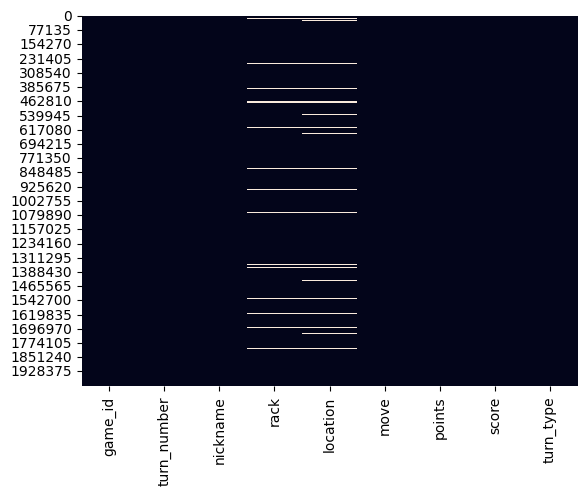

In [ ]:
import seaborn
seaborn.heatmap(turns.isnull(), cbar=False)

# Data Visualization

Let's see how many of each bot played how many games in the training set.

([<matplotlib.patches.Wedge at 0x2a4b66e10>,
 [Text(0.5619092679025921, 0.945652142516038, 'BetterBot'),
  Text(-1.098817783596639, 0.05098508067827218, 'STEEBot'),
  Text(0.5174743141448869, -0.9706803460461529, 'HastyBot')])

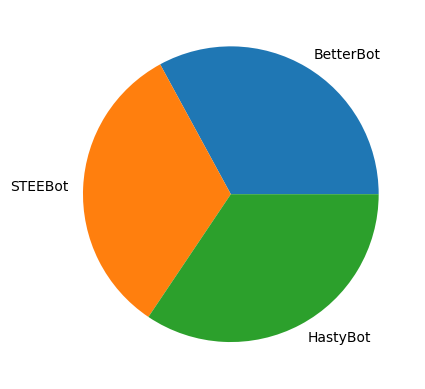

In [ ]:
import matplotlib.pyplot as plot
from collections import Counter

counting = Counter(train["nickname"])

bot_names =["BetterBot", "STEEBot", "HastyBot"]

bot_counts = [counting[bot] for bot in bot_names]

plot.pie(bot_counts, labels =  bot_names, autopct=None)

Let's now visualize the variable we're trying to solve for. We'll want to see how the ratings are distributed.

<Axes: xlabel='rating', ylabel='Count'>

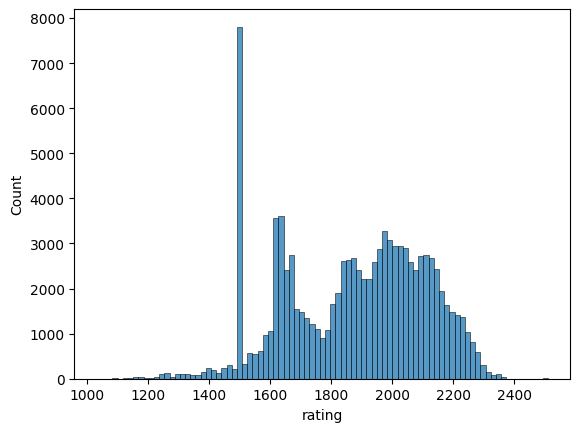

In [ ]:
seaborn.histplot(train['rating'], ax=plot.gca())

We can see here that there seems to be a jump in scores somewhere between 1400 and 1600 for some reason. Let's get more info on that.

In [ ]:
import statistics

print(statistics.mode(train['rating']))

print(list(train['rating']).count(1500))

1500
7575


Looks like we have a most common value of 1500, with 7575 entries. This piques my interest as it seems to come out of nowhere. All the other values around 1500 are low in comparison. So this is very likely to be significant.

Maybe that's the score that a player gets when they first start playing. We should look at the scores with the earliest user creation date later.

First, let's look at how many times each non-bot account played a game.

In [ ]:
non_bot_names = [name for name in counting.keys() if name not in bot_names]
non_bot_counts = [counting[name] for name in non_bot_names]
print(sorted(list(zip(non_bot_counts, non_bot_names)), reverse = True))

[(6576, 'BB-8'), (1759, 'pandorable'), (1029, 'Goldenlamb'), (592, 'HivinD'), (576, 'kar2008'), (561, 'Rexington'), (555, 'Anita'), (522, 'talulah'), (511, 'deathstar'), (503, 'Kovert'), (461, 'Matt_86'), (451, 'Kathleen3'), (441, 'Trayz'), (410, 'stevy'), (399, 'tarkovsky7'), (388, 'Glilac'), (384, 'Esan'), (374, 'NoelL'), (370, 'Zynx'), (369, 'Crookshanks'), (336, 'BethMix'), (318, 'ruby43'), (311, 'thraoph'), (306, 'Xerxes'), (302, 'snorkl'), (300, 'Lola'), (296, 'Yracivc'), (294, 'LeChamp21'), (280, 'pisces223'), (275, 'patricck'), (268, 'NurdiniDelisha'), (264, 'Vishy56789'), (261, 'Laju'), (254, 'gameatiruth'), (254, 'davidavid'), (247, 'TrentonTron'), (246, 'bubbat'), (245, 'jaundiced'), (243, 'bbharath'), (238, 'rak1507'), (236, 'BeautifulWaste'), (235, 'akiff_faleel'), (234, 'wagyus'), (232, 'shaneabbas'), (229, 'PVMG'), (218, 'noahslat'), (217, 'Banman1'), (216, 'shcheah'), (215, 'ChsrQat'), (206, 'atay8'), (205, 'Inandoutworker'), (204, 'MSHS-21KADMUSLEE'), (203, 'Olympicnai

It looks like BB-8 is our most common player, with 6,576 games played.

Let's see what score you get before you've played a game.

For this, it might be useful to merge the dataframes into one main dataframe that has info on all of the games. That way we can sort by created_at which is only in games while also looking at the non-bot nicknames which isn't in games. 

We'll want to make it so that each game_id only has one row, so we'll have to separate the nicknames of bots and non-bots into their own colums, then merge them.

We'll keep the turns dataframe separate for now as it would add a lot of either extra columns or extra rows to our dataframe depending on how we chose to integrate it.

In [ ]:
new_df = pd.concat([train, test])
new_df = new_df.sort_values(by=['game_id'])

non_bot_df = new_df[new_df['nickname'].isin(non_bot_names)]
non_bot_df = non_bot_df.rename(columns={"nickname": "username", "score" : "user_score", "rating": "user_rating"})

bot_df = new_df[new_df['nickname'].isin(bot_names)]
bot_df = bot_df.rename(columns={"nickname": "bot_name", "score" : "bot_score", "rating": "bot_rating"})

combined_df = pd.merge(non_bot_df, bot_df, on='game_id')

combined_df = pd.merge(combined_df, games, on='game_id')

combined_df = combined_df.sort_values(by=['game_id'])

Note: When using a print statement I had earlier, it seems as if game_id = 2 is not included in this dataframe for some reason. This may be an error which causes problems later, yet I shall press on for now.

Now let us see what users' first scores are before they've played a game. We'll assume that the game_id's go in order, so earlier game_id's would indicate earlier created_at's.

In [ ]:
new_list = []
for user in combined_df['username'].unique():
    new_list.append(combined_df[combined_df['username'] == user].iloc[0]['user_rating'])
print(new_list)

[1500.0, 1811.0, 1473.0, 2029.0, 2067.0, 1641.0, 1838.0, 1500.0, 2017.0, 1863.0, 1829.0, 1948.0, 1851.0, 2056.0, 1674.0, 2099.0, 2072.0, 1712.0, 2138.0, 1853.0, 1947.0, 1956.0, 1890.0, 2067.0, 1884.0, 1873.0, 1982.0, 2055.0, 1838.0, 2035.0, 1905.0, 1755.0, 1612.0, 1948.0, 1387.0, 1910.0, 1513.0, 1864.0, 1830.0, 2288.0, 1659.0, 2021.0, 2145.0, 1817.0, 1629.0, 1887.0, 1714.0, 1626.0, 2068.0, 1630.0, 2011.0, 1332.0, 1583.0, 1838.0, 1698.0, 2275.0, 1453.0, 2160.0, 1851.0, 1801.0, 1919.0, 1977.0, 1499.0, 1607.0, 1977.0, 1646.0, 1924.0, 1993.0, 1735.0, 1999.0, 2147.0, 1461.0, 1500.0, 2063.0, 1576.0, 1840.0, 1589.0, 1816.0, 2109.0, 1755.0, 1843.0, 1641.0, 1500.0, 1388.0, 1590.0, 1784.0, 1764.0, 1493.0, 1910.0, 1424.0, 2116.0, 2031.0, 1965.0, 1807.0, 1554.0, 1310.0, 2245.0, 1834.0, 2120.0, 1708.0, 1947.0, 1912.0, 2185.0, 1941.0, 1973.0, 1885.0, 1511.0, 1716.0, 1725.0, 1670.0, 1577.0, 1872.0, 2143.0, 2074.0, 1494.0, 1725.0, 1852.0, 1884.0, 1609.0, 2026.0, 1957.0, 1732.0, 1829.0, 1947.0, 2034.0,

It looks like our hypothesis was wrong: not all users start at 1500 before playing a game. Let's see the percent of users whose first score is 1500.

In [ ]:
len([newer_list for newer_list in new_list if newer_list == 1500])/len(new_list)

0.05058365758754864

It looks like only 5% of players start at 1500. This is a lot less than I expected.

Maybe it has something to do with whether they're playing ranked or not? Or with the lexicon they're using? Or with the time control?

Let's look further into the statistics surrounding rating modes, lexicons, and time controls.

<Axes: xlabel='rating_mode', ylabel='Count'>

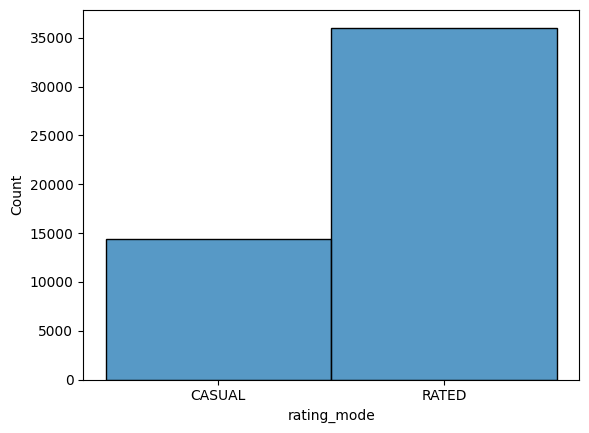

In [ ]:
seaborn.histplot(combined_df['rating_mode'], ax=plot.gca())

Let's look at which rating modes are used the most.

Let's look at which lexicons are used the most.

<Axes: xlabel='lexicon', ylabel='Count'>

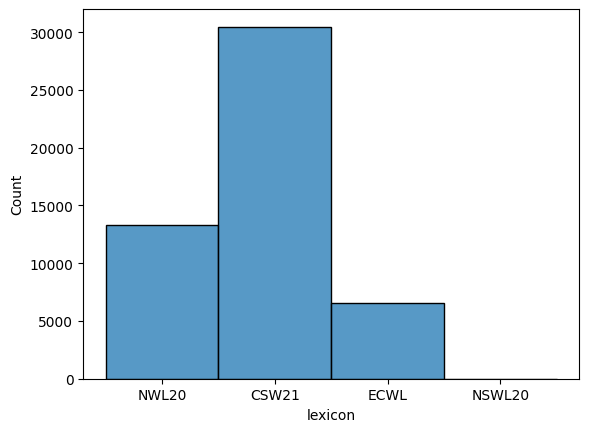

In [ ]:
seaborn.histplot(combined_df['lexicon'], ax=plot.gca())

Let's look at which time controls are used the most.

<Axes: xlabel='time_control_name', ylabel='Count'>

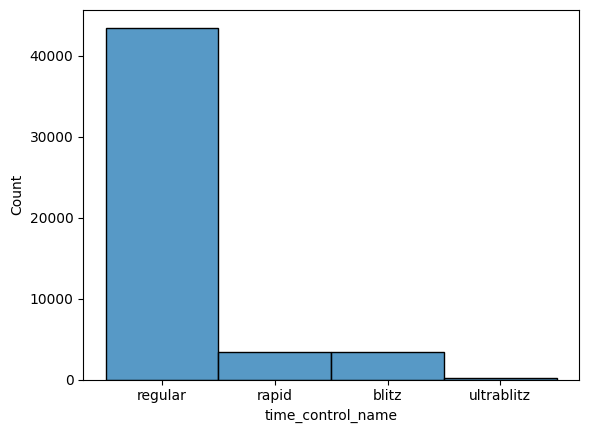

In [ ]:
seaborn.histplot(combined_df['time_control_name'], ax=plot.gca())

So from this we can see that the majority of games are in the regular time control, the CSW21 lexicon, and the rated rating mode. 

So for feature engineering later we may choose to focus more on these areas of the data to get a clearer picture with fewer outliers.

<Axes: xlabel='bot_score', ylabel='Count'>

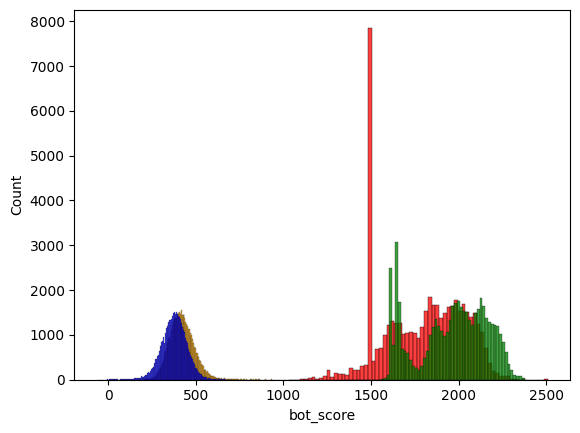

In [ ]:
seaborn.histplot(combined_df['bot_score'], ax=plot.gca(), color = "Orange")

seaborn.histplot(combined_df['user_score'], ax=plot.gca(), color = "Blue")

seaborn.histplot(combined_df['user_rating'], ax=plot.gca(), color = "Red")

seaborn.histplot(combined_df['bot_rating'], ax=plot.gca(), color = "Green")

In the above graph, we can see that bot_score and user_score tend to be similar, whereas bot rating tends to be higher than user rating, and user rating is the one with all of the 1500 scores.

My initial hypothesis was to use linear regression to predict the user rating. We'll want to use the bot rating as a feature to help us predict the user rating. We can use sklearn to do this.

In [ ]:
from sklearn.linear_model import LinearRegression

X_train = train.drop(["nickname", "rating"], axis=1)
y_train = train["rating"].copy()

model = LinearRegression()
model.fit(X_train, y_train)
test["rating"] = model.predict(test.drop(["nickname", "rating"], axis=1))

However, we can actually look at multiple possible solutions and see which one gets us the closest score to what we're looking for. We can do this by looping through each potential solution and seeing which one gets us the closest score. For example, random forests might be a better fit, or maybe a neural network. We can also try different combinations of features to see which ones work best.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

list_of_models = [RandomForestRegressor(), LinearRegression(), MLPRegressor()]

for i in list_of_models:
    X_train = train.drop(["nickname", "rating"], axis=1)
    y_train = train["rating"].copy()
    model = i
    model.fit(X_train, y_train)
    test["rating"] = model.predict(test.drop(["nickname", "rating"], axis=1))
    predictions = model.predict(X_train).reshape(-1)
    RMSE_results = mean_squared_error(y_train, predictions, squared=False)
    print(str(model) + ": " + str(RMSE_results))

RandomForestRegressor(): 87.13202975109137
LinearRegression(): 209.79925483805815
MLPRegressor(): 267.1863896380219


From the results above, it seems like Random Forest Regressor is our best bet.

It should also be noted that MLPRegressor took far longer than the other two methods.

If I were to now upload my data to the Kaggle site, I could get a score on how I did with my predictions compared to the testing ratings. However, for the sake of academic honesty, I will not do this as that would allow others to see my solutions and potentially copy them. However I still have reason to believe my model would do quite well as I assume the testing data will probably be quite similar to hte training data, so my RSME results for the testing data will probably also be close to 87.

The following code creates a CSV file that matches the format of the sample_submission.csv file. It uses the predictions from the Random Forest Regressor model.

In [ ]:
X_train = train.drop(["nickname", "rating"], axis=1)
y_train = train["rating"].copy()
y_train = train["rating"].copy()
model = RandomForestRegressor()
model.fit(X_train, y_train)
test["rating"] = model.predict(test.drop(["nickname", "rating"], axis=1))
submission = test[["game_id", "rating"]]
submission.to_csv("submission.csv", index=False)